<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transfer learning with tensorflow part 3: scaling up (food vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-11-05 12:44:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-05 12:44:23 (132 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, unzip_data

## 101 food classes: working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-11-05 12:44:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.207, 108.177.127.207, 172.217.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  40.4MB/s    in 41s     

2025-11-05 12:45:13 (37.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 image

In [6]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* create a ModelChecpoint callback
* create a data augmentation layer to build data augmentation right in the model
* build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model
* feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [7]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmentation")

In [9]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weigts which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Get the summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.1575 - loss: 3.9622 - val_accuracy: 0.4513 - val_loss: 2.5174
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.4769 - loss: 2.3320 - val_accuracy: 0.5254 - val_loss: 2.0181
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.5563 - loss: 1.9002 - val_accuracy: 0.5429 - val_loss: 1.8391
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.5903 - loss: 1.6948 - val_accuracy: 0.5577 - val_loss: 1.7567
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6215 - loss: 1.5390 - val_accuracy: 0.5641 - val_loss: 1.6933


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5768 - loss: 1.6304


[1.5907684564590454, 0.5833267569541931]

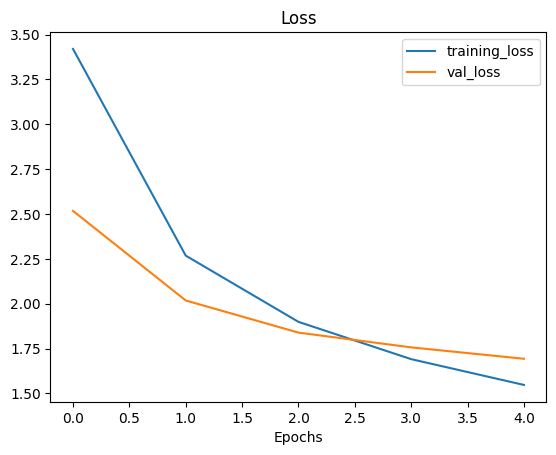

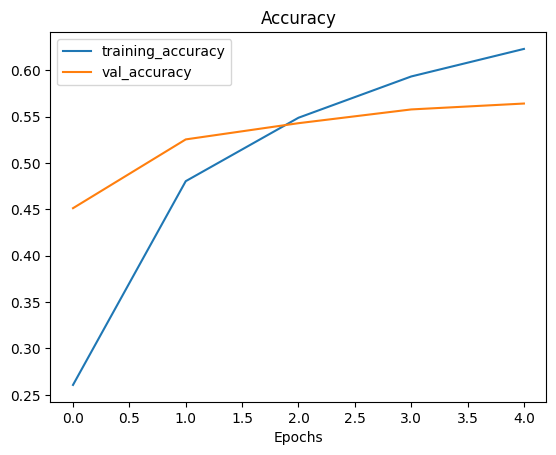

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning_rate reduced by 10x
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.6392 - loss: 1.5136 - val_accuracy: 0.5715 - val_loss: 1.6439
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.6726 - loss: 1.3064 - val_accuracy: 0.5784 - val_loss: 1.6137
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.6964 - loss: 1.2217 - val_accuracy: 0.5818 - val_loss: 1.6045
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.7067 - loss: 1.1703 - val_accuracy: 0.5906 - val_loss: 1.5777
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.7228 - loss: 1.0921 - val_accuracy: 0.5853 - val_loss: 1.5824
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.7425 - loss: 1.0368 - val_accuracy: 0.5887 - val_loss: 1.5724


In [19]:
# Evaluate the whole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.6060 - loss: 1.4870


[1.4134325981140137, 0.6209505200386047]

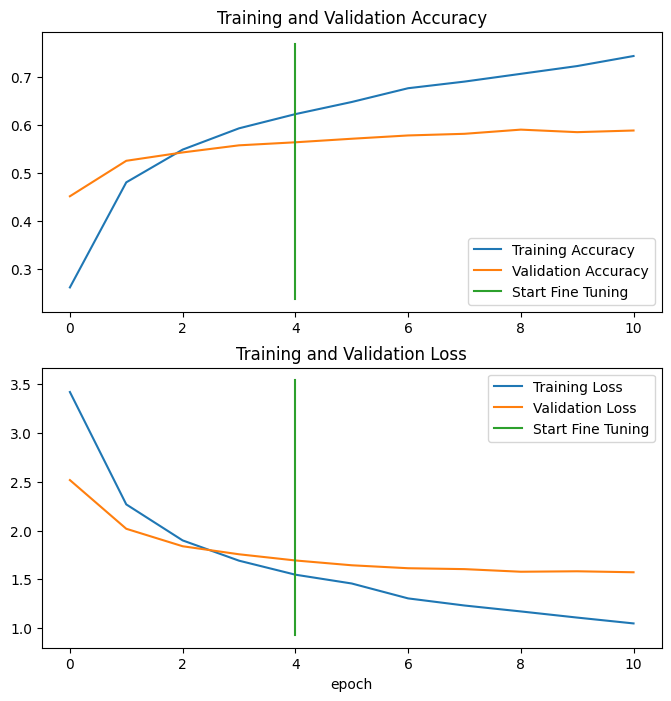

In [20]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [21]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [22]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.6060 - loss: 1.4870


[1.4134325981140137, 0.6209505200386047]

In [24]:
# The results from ourloaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4134325981140137, 0.6209505200386047]

## Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong

In [25]:
import tensorflow as tf

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip

In [26]:
unzip_data('/content/drive/MyDrive/tensorflow_course/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [27]:
!ls -R /content/06_101_food_class_10_percent_saved_big_dog_model/

/content/06_101_food_class_10_percent_saved_big_dog_model/:
assets	saved_model.pb	variables

/content/06_101_food_class_10_percent_saved_big_dog_model/assets:

/content/06_101_food_class_10_percent_saved_big_dog_model/variables:
variables.data-00000-of-00001  variables.index


In [29]:
import tensorflow as tf

# # Load in saved model using tf.saved_model.load
# model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [30]:
# Evaluate the loaded Keras Model on test data
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.6060 - loss: 1.4870


[1.4134325981140137, 0.6209505200386047]

## Make predictions with our trained model

In [31]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step


In [32]:
# How many predictions are there?
len(preds_probs)

25250

In [33]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [34]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.99387777e-01, 2.86804338e-04, 2.00470015e-01, ...,
        5.59967993e-05, 3.92291648e-03, 1.42953023e-02],
       [9.42047834e-01, 2.52276863e-07, 1.83486240e-03, ...,
        7.39087956e-03, 2.19521144e-06, 3.00753600e-05],
       [4.14715052e-01, 1.32335285e-02, 1.53170479e-02, ...,
        8.52091413e-04, 1.09841488e-03, 2.28878693e-03],
       ...,
       [4.60231096e-01, 1.35032205e-05, 2.30903970e-03, ...,
        1.00850143e-01, 1.11824309e-03, 1.76422735e-04],
       [1.56505540e-01, 4.00838442e-04, 3.16012532e-01, ...,
        1.10590493e-03, 2.73363985e-04, 3.16602964e-04],
       [7.90307939e-01, 4.60530964e-06, 3.97391431e-03, ...,
        3.55036557e-03, 1.07621499e-05, 8.74158402e-04]], dtype=float32)

In [35]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.99387777e-01, 2.86804338e-04, 2.00470015e-01, 2.93451171e-06,
        4.19380631e-05, 4.87679426e-06, 4.62449418e-04, 2.03445634e-05,
        2.61525158e-02, 3.04859685e-04, 1.91484542e-05, 4.97165529e-05,
        1.53328688e-03, 1.69150667e-06, 7.25490088e-03, 1.46903913e-03,
        7.12610563e-05, 5.95444487e-03, 6.57292316e-03, 2.70125347e-05,
        1.32251286e-03, 5.12251609e-05, 4.28122265e-04, 6.97050651e-04,
        1.14106282e-03, 3.15672904e-03, 5.30985184e-04, 2.06021825e-04,
        6.90446869e-02, 3.25947464e-03, 1.41804221e-05, 2.06918223e-03,
        6.99567900e-04, 2.78275656e-05, 8.34234897e-03, 4.58160612e-05,
        3.03341192e-04, 1.72102638e-03, 3.41855772e-02, 1.74142202e-04,
        1.07335381e-03, 1.73873035e-03, 8.06256605e-04, 3.28080278e-05,
        1.37575858e-04, 1.04855710e-04, 1.73259119e-03, 1.32872010e-04,
        2.16462904e-05, 1.35625713e-02, 2.73448852e-04, 1.17041382e-04,
        7.20869675e-02, 1.64956003e-02, 1.32120811e-04, 7.618527

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [36]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [3.99387777e-01 2.86804338e-04 2.00470015e-01 2.93451171e-06
 4.19380631e-05 4.87679426e-06 4.62449418e-04 2.03445634e-05
 2.61525158e-02 3.04859685e-04 1.91484542e-05 4.97165529e-05
 1.53328688e-03 1.69150667e-06 7.25490088e-03 1.46903913e-03
 7.12610563e-05 5.95444487e-03 6.57292316e-03 2.70125347e-05
 1.32251286e-03 5.12251609e-05 4.28122265e-04 6.97050651e-04
 1.14106282e-03 3.15672904e-03 5.30985184e-04 2.06021825e-04
 6.90446869e-02 3.25947464e-03 1.41804221e-05 2.06918223e-03
 6.99567900e-04 2.78275656e-05 8.34234897e-03 4.58160612e-05
 3.03341192e-04 1.72102638e-03 3.41855772e-02 1.74142202e-04
 1.07335381e-03 1.73873035e-03 8.06256605e-04 3.28080278e-05
 1.37575858e-04 1.04855710e-04 1.73259119e-03 1.32872010e-04
 2.16462904e-05 1.35625713e-02 2.73448852e-04 1.17041382e-04
 7.20869675e-02 1.64956003e-02 1.32120811e-04 7.61852786e-03
 6.48088520e-03 1.60949025e-03 5.52274985e-0

In [37]:
test_data.class_names[0]

'apple_pie'

In [38]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  2,  0])

In [39]:
# How many pred classes do we have?
len(pred_classes)

25250

 Now we've got a prediction array of all our model's predictions. to evaluate them, we need to compare them to the labels.

In [40]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] #look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [41]:
len(y_labels)

25250

## Evaluate our model's predictions

In [42]:
results_downloaded_model

[1.4134325981140137, 0.6209505200386047]

In [43]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.620950495049505

In [48]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

np.True_